# 实验介绍
本实验是基于Keras+tensorflow（作为后端），已movie_lens 数据集为训练数据，进行电影评论数据的分类（预测评论是正面还是负面）的实验。
# 实验步骤
* 定义训练数据：下载movie_lens 数据集，keras库中已经包含了预处理好的数据集，此次未使用原始数据集，对数据进行预处理，已符合网络的输入结构
* 定义层组成的网络：需要几层网络，每层网络的输出和输入维度，也就是将输入数据映射到多少维的空间中，网络相当于过滤器，会对数据进行层层萃取已获取输入数据的最合适的表现方式，本质上就是通过网络进行学习对应的参数
* 配置学习过程：学习过程就是网络的目标是学习到输入数据的有用表达方式，这个获取这个表达方式的过程就是学习，为了更好的学习并达到目的，需要通过一些监控手段对学习过程进行监控，这里我们会使用损失函数来进行监控，损失函数是用于评估学习后的参数经过预测与目标值的偏差，这个偏差越小越好，为了更好的找到这个缩小偏差的方法，我们引入了优化器 优化器是通过损失函数的结果作为反馈信号，再通过优化器进行优化参数进行再次的训练已达到最终最小偏差为目的，优化器的实现机制是通过SDG随机梯度下降的方法来实现的。 因此我们需要在配置环境配置 损失函数，优化器，以及我们监控的指标 比如精度
* 进行模型训练

下来我们根据上面的步骤基于次实验场景进行具体训练和解说：

# 定义训练数据

In [1]:
from keras.datasets import imdb

Using TensorFlow backend.


In [2]:
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words = 10000)
# 仅保留训练数据中前100000个最常出现的单词，低品词将被舍弃

## 数据分析

In [3]:
train_data[0] #查看第一个样本数据，这里存储的是经过索引后的数据，每个值代表当前词在字典中的索引

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
train_labels[0] #查看标签数据，0表示负面 1表示正面评论

1

In [5]:
max([max(sequence) for sequence in train_data]) # 查看整个训练数据集中 最大的索引数，因为限制了10000个常用词 所以大小为9999

9999

下来我们将训练数据转换为英文看一下内容

In [6]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [7]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

可以看出train_data[0] 这个样本是正面的因此标签为1，数据是正常的

## 准备数据

因为上面的整数序列值不能直接输入到网络中，因此需要对数据先进行处理转换为张量，常用的方法有两种
* 填充序列：使其具有相同的长度，再将列表转换为 (samples,word_indicies)的格式
* 对列表进行one-hot 编码，将其转为0和1组成的向量

In [8]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

查看一下向量话后的数据

In [9]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

可以看到样本数据已经被做了编码，现在是有0，1数字组成的向量，下面对标签数据进行向量话，由于我们输出网络是介于0-1之间的值，同时42个分类的概率综合是1，所以对标签进行处理

In [11]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# 构建网络
* 输入数据是向量，而标签是标量，这是一种常见的问题，这种类型的输入和输出非常使用使用带有relu 激活的全连接层（Dense）的简单堆叠。
* 影响网络的另一个因素是Dense层的第一个参数，隐藏单元，这个代表 表示空间的维度，也就是将输入数据与W参数做点击然后投影到16维空间中，隐藏单元越多说明投影到更高维度，隐藏单元越多能够学到更复杂的表示，单网络计算代价也越大。
对于该需求而言我们采用如下网络：
* 两个中间层，都采用全连接层，同时使用relu来进行激活
* 同时每层都有16个隐藏单元
* 第三层输出一个标量，采用sigmoid 将输出的值压缩到[0，1] 之间的数据

In [12]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

下来我们对网络进行设置，需要设置包括优化器和损失函数：
* 优化器 rmsprop ,用于根据损失函数的反馈信号更新参数
* 损失函数 选择 binary_crosssentropy 二元交叉熵 ，用于评估训练后预测值与真实值间的变差

In [13]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 模型训练

In [24]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

模型训练
模型训练时可以设置参数来进行模型训练阶段的调节，这里包括epoch 轮次，批量 batch_size 
* epoch 轮次，表示的是在全量数据训练的次数，比如下面是训练20次。
* batch_size 批次，每次进行随机梯度下降计算的输入数据大小，每批的数据都是随机抽取的
* learning_rate 也就是步长，表示每次梯度下降的长度，这个值越小需要更多的时间，太大可能会出现左右摆动的问题
* 对于可能存在的局部最小点问题，是通过带有动量的SGD或者rmsprop的实现来解决

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 1s 99us/step - loss: 0.5125 - accuracy: 0.7863 - val_loss: 0.3974 - val_accuracy: 0.8576
Epoch 2/20
15000/15000 [==============================] - 1s 74us/step - loss: 0.3003 - accuracy: 0.9038 - val_loss: 0.3014 - val_accuracy: 0.8860
Epoch 3/20
15000/15000 [==============================] - 1s 75us/step - loss: 0.2177 - accuracy: 0.9277 - val_loss: 0.3396 - val_accuracy: 0.8593
Epoch 4/20
15000/15000 [==============================] - 1s 74us/step - loss: 0.1737 - accuracy: 0.9433 - val_loss: 0.2770 - val_accuracy: 0.8905
Epoch 5/20
15000/15000 [==============================] - 1s 75us/step - loss: 0.1376 - accuracy: 0.9566 - val_loss: 0.2845 - val_accuracy: 0.8880
Epoch 6/20
15000/15000 [==============================] - 1s 74us/step - loss: 0.1146 - accuracy: 0.9642 - val_loss: 0.3303 - val_accuracy: 0.8726
Epoch 7/20
15000/15000 [==============================] - 1s 79us/st

## 模型评估于优化

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

history 中包含了训练过程中的数据，可以通过history来查看训练过程

In [20]:
! pip install matplotlib

     |████████████████████████████████| 11.6 MB 8.3 MB/s eta 0:00:01
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
     |████████████████████████████████| 1.1 MB 79.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [21]:
import matplotlib.pyplot as plt

下来我们通过maplotlib 库绘制一下，模型训练过程中，精度，损失 在训练数据和验证数据的变化，同这个来评估模型的效果，
* 我们构建一个已轮次为X轴
* 已训练数据损失和验证数据损失 为Y轴
* 用于观察训练阶段和验证阶段在不同轮次上的变化趋势

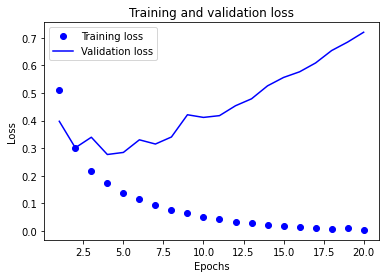

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"  训练损失
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"  验证损失
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

由上图可以观察到以下信息：
* 轮次在2.5 以后，训练损失随着轮次的增加逐渐减小
* 轮次在2.5以后，验证损失随着轮次的增加逐渐增大
这种在训练阶段表现很高，但是在验证数据表现差的场景，教过模型的过拟合，也就是说模型在新鲜数据上表现要差于训练阶段。 过拟合产生的原因由多种
* 本例子关注因为训练轮次的变化产生的过拟合问题
* 当然还包括数据的影响，因为在训练阶段数据的个性化不足，导致训练出的模型无法泛化到新数据上而引起过拟合

绘制训练阶段和雁阵阶段的精度趋势

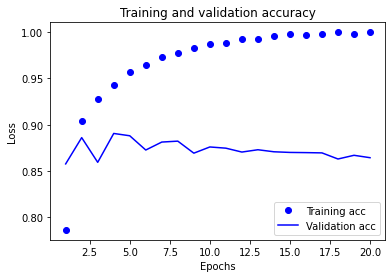

In [29]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

由上图可以观察到以下信息：
* 轮次在2.5 以后，训练精度在不断提高
* 验证损失2.5 以后 出现下降，5以后基本出于逐渐下降的趋势
原因同上面的分析


如上面的分析我们可以看到轮次在大概4以后，模型的精度一直出于下降，因此我们可以优化轮次为4再进行训练（这里的轮次就是超参数）

In [32]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 1s 44us/step - loss: 0.4483 - accuracy: 0.8242
Epoch 2/4
25000/25000 [==============================] - 1s 41us/step - loss: 0.2575 - accuracy: 0.9090
Epoch 3/4
25000/25000 [==============================] - 1s 41us/step - loss: 0.2004 - accuracy: 0.9282
Epoch 4/4
25000/25000 [==============================] - 2s 67us/step


In [33]:
results

[0.30169105003356933, 0.8808000087738037]

上面是在侧数据上的损失和精度

## 模型推理

In [35]:
model.predict(x_test)

array([[0.27590933],
       [0.9999838 ],
       [0.94255143],
       ...,
       [0.16744263],
       [0.09262326],
       [0.66663593]], dtype=float32)

# 实验：进一步测试

* 尝试使用具有更多隐藏单位或更少隐藏单位的图层：32 个单位，64 个单位...
* 尝试使用 mse 损失函数而不是 binary_crossentropy。
* 尝试使用 tanh 激活（神经网络早期流行的激活）而不是 relu。

## 使用64个单元 
也就是将输入映射到64维的张量来表示

In [45]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=4,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 1s 67us/step - loss: 0.4632 - accuracy: 0.8292 - val_loss: 0.3294 - val_accuracy: 0.8826
Epoch 2/4
15000/15000 [==============================] - 1s 61us/step - loss: 0.2485 - accuracy: 0.9121 - val_loss: 0.2731 - val_accuracy: 0.8928
Epoch 3/4
15000/15000 [==============================] - 1s 60us/step - loss: 0.1807 - accuracy: 0.9351 - val_loss: 0.2767 - val_accuracy: 0.8902
Epoch 4/4
15000/15000 [==============================] - 1s 60us/step - loss: 0.1421 - accuracy: 0.9509 - val_loss: 0.2941 - val_accuracy: 0.8867


In [46]:
results = model.evaluate(x_test, y_test)
results

25000/25000 [==============================] - 2s 61us/step


[0.31359747153759004, 0.8774799704551697]

* 16 维 0.30169105003356933, 0.8808000087738037
* 64 维 之前是 , 通过增加神经单元的个数也就是投射的维度，模型在测试集上的效果反而变差了。 [0.3028281346178055, 0.8791999816894531]
* 8 维 [0.2921900947189331, 0.8834800124168396]


减小batch-size 试一下，从512 调整为128后效果有所下降  [0.31359747153759004, 0.8774799704551697]

## 使用MSE作为损失函数

In [50]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=4,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 1s 84us/step - loss: 0.0131 - accuracy: 0.9863 - val_loss: 0.0984 - val_accuracy: 0.8731
Epoch 2/4
15000/15000 [==============================] - 1s 79us/step - loss: 0.0100 - accuracy: 0.9911 - val_loss: 0.1021 - val_accuracy: 0.8724
Epoch 3/4
15000/15000 [==============================] - 1s 78us/step - loss: 0.0082 - accuracy: 0.9935 - val_loss: 0.1022 - val_accuracy: 0.8718
Epoch 4/4
15000/15000 [==============================] - 1s 79us/step - loss: 0.0069 - accuracy: 0.9943 - val_loss: 0.1057 - val_accuracy: 0.8678


In [49]:
results = model.evaluate(x_test, y_test)
results

25000/25000 [==============================] - 1s 59us/step


[0.11349301282286645, 0.8547999858856201]

从测试效果看，使用MSE作为损失函数后，测试集上的精度下降了0.04个百分点，说明mse 不如 二分类交叉熵效果好

## 使用tanh作为激活函数

In [52]:
model = models.Sequential()
model.add(layers.Dense(16, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

ValueError: Unknown loss function:tanh